<a href="https://colab.research.google.com/github/sedainp869/Assignments-BDA58/blob/main/Project%208%20-%20Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1: Collect Historical Stock Data

In [4]:
import yfinance as yf

# Define the ticker symbol
ticker = 'TSLA'
# Download historical stock data
data = yf.download(ticker, start='2020-01-01', end='2023-10-01')
print(data.head())


[*********************100%***********************]  1 of 1 completed

                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-01-02  28.299999  28.713333  28.114000  28.684000  28.684000  142981500
2020-01-03  29.366667  30.266666  29.128000  29.534000  29.534000  266677500
2020-01-06  29.364668  30.104000  29.333332  30.102667  30.102667  151995000
2020-01-07  30.760000  31.441999  30.224001  31.270666  31.270666  268231500
2020-01-08  31.580000  33.232666  31.215334  32.809334  32.809334  467164500


Clean and Preprocess Data

In [5]:
# Check for missing values
print(data.isnull().sum())

# Remove missing values
data.dropna(inplace=True)

# Handling outliers (example: using Z-score)
from scipy import stats

z_scores = stats.zscore(data['Close'])
data = data[(z_scores < 3) & (z_scores > -3)]
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data['Normalized_Close'] = scaler.fit_transform(data[['Close']])


Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


Feature Engineering

In [6]:
# Moving averages
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['MA_50'] = data['Close'].rolling(window=50).mean()

# Volatility (standard deviation of returns)
data['Volatility'] = data['Close'].pct_change().rolling(window=20).std()

# Display the engineered features
print(data[['Close', 'MA_20', 'MA_50', 'Volatility']].head())


                Close  MA_20  MA_50  Volatility
Date                                           
2020-01-02  28.684000    NaN    NaN         NaN
2020-01-03  29.534000    NaN    NaN         NaN
2020-01-06  30.102667    NaN    NaN         NaN
2020-01-07  31.270666    NaN    NaN         NaN
2020-01-08  32.809334    NaN    NaN         NaN


Select Prediction Models

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
# Assuming 'data' is your DataFrame after preprocessing
data_cleaned = data.copy() # Create a copy to avoid modifying the original DataFrame

# Features and target variable
X = data_cleaned[['Open', 'High', 'Low', 'MA_50', 'Volatility']]
y = data_cleaned['Close']

# Remove rows with NaN values in the features or target
X.dropna(inplace=True)
y = y[X.index]  # Align the target variable with the cleaned features

#Split the data into training (80%) and testing (20%) sets

#t the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

<ipython-input-17-62b82504f6d9>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.dropna(inplace=True)


RandomForestRegressor(random_state=42)

Evaluate Model Performance

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Make sure to use the correct model (either lr_model or rf_model)
y_pred = lr_model.predict(X_test)  # Or rf_model.predict(X_test) if you want to evaluate the Random Forest model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse}, MAE: {mae}")

RMSE: 2.7567130182229334, MAE: 1.9913588233594888


Deploy the Prediction Model and stock forcast

In [22]:
import joblib
joblib.dump(rf_model, 'stock_price_predictor.pkl')
loaded_model = joblib.load('stock_price_predictor.pkl')
# Use the trained model to make future predictions (on the test set as a demonstration)
future_predictions = loaded_model.predict(X_test)
# Display the predicted values
print(future_predictions[:10])  # Show the first 10 predictions


[121.59073929 346.09736786 338.85730682 142.41505203  53.14499939
 228.11743286 195.58699982 217.10686768 288.06883209 131.9802504 ]


Visualization

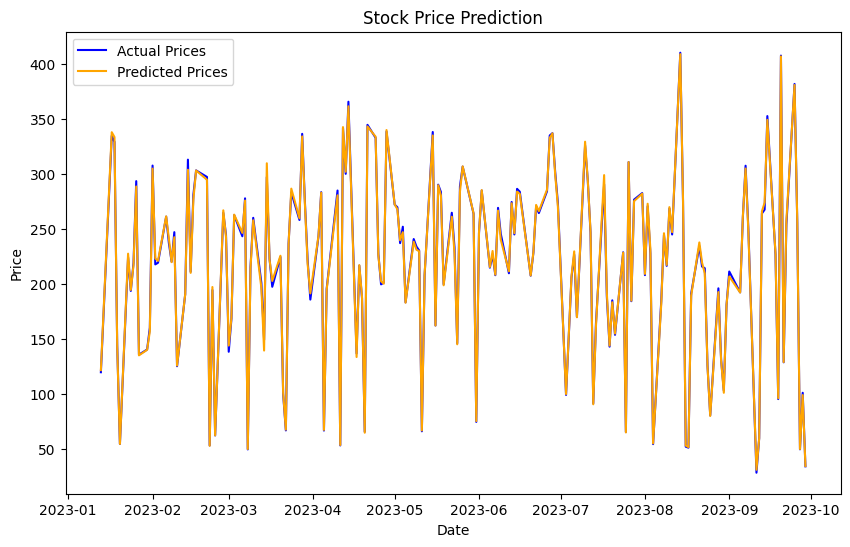

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Actual Prices', color='blue')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Prices', color='orange')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
